In [1]:
# Importations nécessaires
import pandas as pd
import re
import torch
from transformers import (
    CamembertTokenizer,
    CamembertModel,
    AdamW,
    get_linear_schedule_with_warmup,
)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
import nltk
import emoji
import nltk
from nltk.corpus import stopwords

/Users/mac/TangerMedFilter/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Chargement des données
data = pd.read_csv("/Users/mac/TangerMedFilter/dataset/DataSetTM.csv")
data.head()

,comments,labels
0,Le groupe TangerMed ne se contente pas de gére...,1
1,Avec une présence stratégique dans 9 ports au ...,1
2,L'avenir du transport maritime en Afrique pass...,1
3,Mon Maroc toujours en avant ❤️❤️❤️,1
4,Bravo pour un travail brillamment exécuté mon ami,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  800 non-null    object
 1   labels    800 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.6+ KB


<Axes: ylabel='labels'>

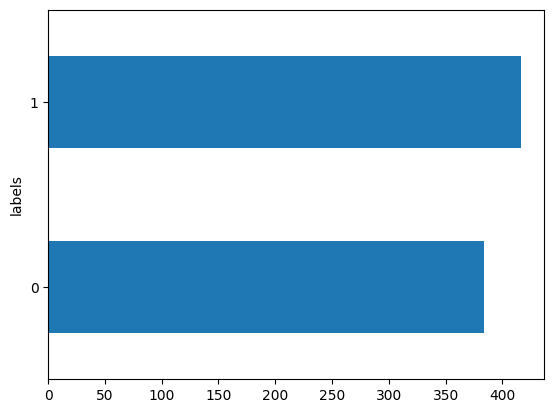

In [4]:
label_counts = data["labels"].value_counts(ascending=True)
label_counts.plot.barh()

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Charger le modèle et le tokenizer CamemBERT (camembert-base)
model_ckpt = "camembert-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt)

# Texte à tokenizer
text = "J'adore l'apprentissage automatique ! La tokenisation est géniale !!"

# Tokenisation du texte
encoded_text = tokenizer(text, return_tensors="pt")  # return_tensors='pt' pour PyTorch

# Affichage des résultats
print(encoded_text)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'input_ids': tensor([[    5,   121,    11,  1990,    17,    11,  3215,  3314,    83,    61,
          1200,  6840,  1385,    30, 16045,  1313,     6]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, stratify=data["labels"])
test, validation = train_test_split(test, test_size=1 / 3, stratify=test["labels"])
train.shape, test.shape, validation.shape

((560, 2), (160, 2), (80, 2))

In [7]:
from datasets import Dataset, DatasetDict  # Import both Dataset and DatasetDict

dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(train, preserve_index=False),
        "test": Dataset.from_pandas(test, preserve_index=False),
        "validation": Dataset.from_pandas(validation, preserve_index=False),
    }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['comments', 'labels'],
        num_rows: 560
    })
    test: Dataset({
        features: ['comments', 'labels'],
        num_rows: 160
    })
    validation: Dataset({
        features: ['comments', 'labels'],
        num_rows: 80
    })
})

In [8]:
def tokenizer_function(batch):
    # Apply tokenization to the 'comments' column in the batch
    temp = tokenizer(batch["comments"], padding=True, truncation=True)
    return temp


# Affichage du commentaire original et du résultat de la tokenisation avec espace
original_comment = dataset["train"][0]["comments"]
tokenized_result = tokenizer_function(dataset["train"][0])

# Utilisation de f-strings pour ajouter des espaces et afficher les résultats
print(
    f"Commentaire original : {original_comment}\n\nRésultat de la tokenisation : {tokenized_result}"
)

Commentaire original : Quant à l'argument selon lequel les habitants de la région n'ont pas le niveau d'études pour occuper des postes dans ce port c'est sans fondement. En réalité ceux qui contrôlent les choses...

Résultat de la tokenisation : {'input_ids': [5, 2474, 15, 17, 11, 11761, 395, 966, 19, 1384, 8, 13, 581, 49, 11, 263, 34, 16, 359, 18, 11, 4201, 24, 9295, 20, 4045, 29, 44, 1406, 60, 11, 41, 112, 13495, 9, 107, 1033, 320, 31, 963, 113, 19, 541, 57, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [9]:
dataset = dataset.map(tokenizer_function, batched=True, batch_size=None)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
Map: 100%|██████████| 80/80 [00:00<00:00, 12967.90 examples/s]


In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['comments', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 560
    })
    test: Dataset({
        features: ['comments', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 160
    })
    validation: Dataset({
        features: ['comments', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 80
    })
})

In [11]:
from transformers import AutoModel
import torch

model = AutoModel.from_pretrained(model_ckpt)
model

CamembertModel(
  (embeddings): CamembertEmbeddings(
    (word_embeddings): Embedding(32005, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): CamembertEncoder(
    (layer): ModuleList(
      (0-11): 12 x CamembertLayer(
        (attention): CamembertAttention(
          (self): CamembertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): CamembertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
 

In [12]:
# Ajouter le mapping des labels au modèle
num_labels = 2  # Nombre de classes, ici binaire (ex : négatif, positif)
label2id = {"negatif": 0, "positif": 1}  # Mapping de label à id
id2label = {0: "negatif", 1: "positif"}  # Mapping de id à label

In [13]:
label2id

{'negatif': 0, 'positif': 1}

In [14]:
id2label

{0: 'negatif', 1: 'positif'}

In [16]:
from transformers import AutoModelForSequenceClassification
import torch
import torch.nn as nn

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CustomCamembertModel(nn.Module):
    def __init__(self, num_labels=2, id2label=id2label, label2id=label2id):
        super(CustomCamembertModel, self).__init__()
        self.camembert = AutoModelForSequenceClassification.from_pretrained(
            model_ckpt, num_labels=num_labels
        )
        self.fc1 = nn.Linear(768, 68)  # Première couche fully-connected
        self.fc2 = nn.Linear(68, num_labels)  # Deuxième couche fully-connected
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.id2label = id2label  # Mapping des labels
        self.label2id = label2id  # Mapping des labels
        self.num_labels = num_labels  # Store num_labels as an attribute

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.camembert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Utiliser les logits directement

        loss = None
        if labels is not None:  # Calculate loss if labels are provided
            loss_fct = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for classification
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {
            "loss": loss,
            "logits": logits,
        }  # Return a dictionary containing loss and logits

In [17]:
from transformers import AutoModelForSequenceClassification
import torch
import torch.nn as nn


# Modèle personnalisé basé sur CamemBERT avec une seule couche fully-connected (768 -> 2)
class CustomCamembertModel(nn.Module):
    def __init__(
        self,
        num_labels=2,
        id2label=id2label,
        label2id=label2id,
        model_ckpt="camembert-base",
    ):
        super(CustomCamembertModel, self).__init__()
        self.camembert = AutoModelForSequenceClassification.from_pretrained(model_ckpt)
        self.fc = nn.Linear(768, num_labels)  # Couche fully-connected unique (768 -> 2)
        self.dropout = nn.Dropout(0.1)  # Dropout pour la régularisation
        self.id2label = id2label  # Mapping des labels
        self.label2id = label2id  # Mapping des labels
        self.num_labels = num_labels  # Nombre de classes

    def forward(self, input_ids, attention_mask, labels=None):
        # Passage du modèle CamemBERT
        outputs = self.camembert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[
            :, 0, :
        ]  # Prendre la sortie du token [CLS]

        # Application du dropout et de la couche fully-connected
        x = self.dropout(cls_output)
        logits = self.fc(x)  # Logits pour les classes (2 classes)

        loss = None
        if labels is not None:
            loss_fct = (
                nn.CrossEntropyLoss()
            )  # Calcul de la loss si les labels sont fournis
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {
            "loss": loss,
            "logits": logits,
        }  # Retourne un dictionnaire avec la loss et les logits

In [18]:
import torch

torch.cuda.empty_cache()

In [20]:
# 6. Initialiser le modèle
num_labels = len(label2id)
model = CustomCamembertModel(num_labels=num_labels)
model

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomCamembertModel(
  (camembert): CamembertForSequenceClassification(
    (roberta): CamembertModel(
      (embeddings): CamembertEmbeddings(
        (word_embeddings): Embedding(32005, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): CamembertEncoder(
        (layer): ModuleList(
          (0-11): 12 x CamembertLayer(
            (attention): CamembertAttention(
              (self): CamembertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): CamembertSelfOu

In [21]:
model.id2label, model.label2id

({0: 'negatif', 1: 'positif'}, {'negatif': 0, 'positif': 1})

In [22]:
from transformers import TrainingArguments, Trainer, TrainerCallback, AdamW
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Définir les arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./camembert_train_dir",
    eval_strategy="epoch",  # Remplacez `evaluation_strategy` par `eval_strategy`
    learning_rate=0.00005,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.001,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
)


# Instancier le modèle avec la bonne architecture pour la classification
# model = CustomCamembertModel(num_labels=num_labels)
model = AutoModelForSequenceClassification.from_pretrained(
    "camembert-base", num_labels=num_labels
)  # Use AutoModelForSequenceClassification for classification


# Fonction pour calculer les métriques
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)

    return {
        "accuracy": accuracy,
    }


# Callback pour afficher les métriques
class MetricsLogger(TrainerCallback):
    def on_epoch_end(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            print(f"Époque {state.epoch}/{args.num_train_epochs}:")
            print(f" - Perte d'entraînement: {metrics['train_loss']:.4f}")
            print(f" - Précision d'entraînement: {metrics['train_accuracy']:.4f}")
            print(f" - Perte de validation: {metrics['eval_loss']:.4f}")
            print(f" - Précision de validation: {metrics['eval_accuracy']:.4f}\n")


# Créer l'optimiseur
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)

# Créer le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[MetricsLogger()],
    optimizers=(
        optimizer,
        None,
    ),  # Passer l'optimiseur, le second est le scheduler (None ici)
)

# Fine-tuning
trainer.train()

# Évaluation finale
eval_result = trainer.evaluate()
print("\n=== Résultats sur l'ensemble d'entraînement ===")
print(f"Accuracy (Train): {eval_result['eval_accuracy']:.4f}")

# Évaluation finale sur le jeu de test
test_result = trainer.evaluate(
    eval_dataset=dataset["test"]
)  # Assurez-vous d'avoir un dataset 'test'
print("\n=== Résultats sur l'ensemble de test ===")
print(f"Test Accuracy: {test_result['eval_accuracy']:.4f}")

# Obtenez les prédictions pour le rapport de classification
test_preds = trainer.predict(dataset["test"])
test_labels = test_preds.label_ids
test_predictions = np.argmax(test_preds.predictions, axis=1)

# Afficher le rapport de classification uniquement à la fin
report = classification_report(test_labels, test_predictions)
print("\n=== Rapport de classification pour le jeu de test ===")
print(report)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/mac/TangerMedFilter/env/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/var/folders/97/fhshf9jn3xj5w3sj_t01xqvm0000gn/T/ipykernel_1046/3608285074.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  4%|▎         | 10/280 [00:27<08:41,  1.93s/it]

{'loss': 0.6869, 'grad_norm': 1.4067420959472656, 'learning_rate': 4.8214285714285716e-05, 'epoch': 0.29}


  7%|▋         | 20/280 [00:44<06:59,  1.61s/it]

{'loss': 0.6517, 'grad_norm': 1.4573863744735718, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.57}


 11%|█         | 30/280 [01:00<06:40,  1.60s/it]

{'loss': 0.5003, 'grad_norm': 1.3782960176467896, 'learning_rate': 4.464285714285715e-05, 'epoch': 0.86}


                                                
 12%|█▎        | 35/280 [01:10<06:34,  1.61s/it]

{'eval_loss': 0.24871177971363068, 'eval_accuracy': 0.9625, 'eval_runtime': 2.5426, 'eval_samples_per_second': 31.464, 'eval_steps_per_second': 3.933, 'epoch': 1.0}


 14%|█▍        | 40/280 [01:26<10:17,  2.57s/it]

{'loss': 0.3291, 'grad_norm': 0.995544970035553, 'learning_rate': 4.2857142857142856e-05, 'epoch': 1.14}


 18%|█▊        | 50/280 [01:43<06:19,  1.65s/it]

{'loss': 0.2782, 'grad_norm': 4.10967493057251, 'learning_rate': 4.107142857142857e-05, 'epoch': 1.43}


 21%|██▏       | 60/280 [01:59<06:06,  1.67s/it]

{'loss': 0.2699, 'grad_norm': 0.5074228048324585, 'learning_rate': 3.928571428571429e-05, 'epoch': 1.71}


 25%|██▌       | 70/280 [02:16<05:39,  1.62s/it]

{'loss': 0.187, 'grad_norm': 0.6178117394447327, 'learning_rate': 3.7500000000000003e-05, 'epoch': 2.0}


                                                
 25%|██▌       | 70/280 [02:17<05:39,  1.62s/it]

{'eval_loss': 0.13762632012367249, 'eval_accuracy': 0.9625, 'eval_runtime': 1.5639, 'eval_samples_per_second': 51.154, 'eval_steps_per_second': 6.394, 'epoch': 2.0}


 29%|██▊       | 80/280 [02:39<05:39,  1.70s/it]

{'loss': 0.1174, 'grad_norm': 0.5210053324699402, 'learning_rate': 3.571428571428572e-05, 'epoch': 2.29}


 32%|███▏      | 90/280 [02:56<05:16,  1.67s/it]

{'loss': 0.172, 'grad_norm': 0.42222368717193604, 'learning_rate': 3.392857142857143e-05, 'epoch': 2.57}


 36%|███▌      | 100/280 [03:12<04:56,  1.65s/it]

{'loss': 0.1134, 'grad_norm': 0.238167405128479, 'learning_rate': 3.2142857142857144e-05, 'epoch': 2.86}


                                                 
 38%|███▊      | 105/280 [03:22<04:39,  1.60s/it]

{'eval_loss': 0.12662310898303986, 'eval_accuracy': 0.9625, 'eval_runtime': 1.7788, 'eval_samples_per_second': 44.973, 'eval_steps_per_second': 5.622, 'epoch': 3.0}


 39%|███▉      | 110/280 [03:35<05:54,  2.09s/it]

{'loss': 0.081, 'grad_norm': 0.23057009279727936, 'learning_rate': 3.0357142857142857e-05, 'epoch': 3.14}


 43%|████▎     | 120/280 [03:51<04:15,  1.60s/it]

{'loss': 0.0325, 'grad_norm': 201.34645080566406, 'learning_rate': 2.857142857142857e-05, 'epoch': 3.43}


 46%|████▋     | 130/280 [04:07<04:01,  1.61s/it]

{'loss': 0.0737, 'grad_norm': 0.1584167331457138, 'learning_rate': 2.6785714285714288e-05, 'epoch': 3.71}


 50%|█████     | 140/280 [04:23<03:41,  1.58s/it]

{'loss': 0.1626, 'grad_norm': 0.14340341091156006, 'learning_rate': 2.5e-05, 'epoch': 4.0}


                                                 
 50%|█████     | 140/280 [04:24<03:41,  1.58s/it]

{'eval_loss': 0.16078229248523712, 'eval_accuracy': 0.9625, 'eval_runtime': 1.4708, 'eval_samples_per_second': 54.392, 'eval_steps_per_second': 6.799, 'epoch': 4.0}


 54%|█████▎    | 150/280 [04:45<03:38,  1.68s/it]

{'loss': 0.043, 'grad_norm': 0.1361168622970581, 'learning_rate': 2.3214285714285715e-05, 'epoch': 4.29}


 57%|█████▋    | 160/280 [05:02<03:11,  1.60s/it]

{'loss': 0.0904, 'grad_norm': 0.556605339050293, 'learning_rate': 2.1428571428571428e-05, 'epoch': 4.57}


 61%|██████    | 170/280 [05:18<02:55,  1.60s/it]

{'loss': 0.0407, 'grad_norm': 0.17086288332939148, 'learning_rate': 1.9642857142857145e-05, 'epoch': 4.86}


                                                 
 62%|██████▎   | 175/280 [05:27<02:50,  1.62s/it]

{'eval_loss': 0.16745829582214355, 'eval_accuracy': 0.9625, 'eval_runtime': 1.549, 'eval_samples_per_second': 51.648, 'eval_steps_per_second': 6.456, 'epoch': 5.0}


 64%|██████▍   | 180/280 [05:41<03:32,  2.13s/it]

{'loss': 0.0136, 'grad_norm': 0.11712806671857834, 'learning_rate': 1.785714285714286e-05, 'epoch': 5.14}


 68%|██████▊   | 190/280 [05:58<02:28,  1.65s/it]

{'loss': 0.0273, 'grad_norm': 0.11058270931243896, 'learning_rate': 1.6071428571428572e-05, 'epoch': 5.43}


 71%|███████▏  | 200/280 [06:15<02:12,  1.66s/it]

{'loss': 0.0108, 'grad_norm': 0.09552617371082306, 'learning_rate': 1.4285714285714285e-05, 'epoch': 5.71}


 75%|███████▌  | 210/280 [06:31<01:53,  1.62s/it]

{'loss': 0.0946, 'grad_norm': 1.7657564878463745, 'learning_rate': 1.25e-05, 'epoch': 6.0}


                                                 
 75%|███████▌  | 210/280 [06:33<01:53,  1.62s/it]

{'eval_loss': 0.17555300891399384, 'eval_accuracy': 0.9625, 'eval_runtime': 1.5531, 'eval_samples_per_second': 51.509, 'eval_steps_per_second': 6.439, 'epoch': 6.0}


 79%|███████▊  | 220/280 [06:56<01:54,  1.91s/it]

{'loss': 0.0912, 'grad_norm': 25.919326782226562, 'learning_rate': 1.0714285714285714e-05, 'epoch': 6.29}


 82%|████████▏ | 230/280 [07:13<01:23,  1.66s/it]

{'loss': 0.0639, 'grad_norm': 0.10684242099523544, 'learning_rate': 8.92857142857143e-06, 'epoch': 6.57}


 86%|████████▌ | 240/280 [07:29<01:05,  1.63s/it]

{'loss': 0.0112, 'grad_norm': 0.09721208363771439, 'learning_rate': 7.142857142857143e-06, 'epoch': 6.86}


                                                 
 88%|████████▊ | 245/280 [07:39<00:57,  1.63s/it]

{'eval_loss': 0.17875757813453674, 'eval_accuracy': 0.9625, 'eval_runtime': 1.504, 'eval_samples_per_second': 53.191, 'eval_steps_per_second': 6.649, 'epoch': 7.0}


 89%|████████▉ | 250/280 [07:52<01:03,  2.12s/it]

{'loss': 0.036, 'grad_norm': 0.10749895870685577, 'learning_rate': 5.357142857142857e-06, 'epoch': 7.14}


 93%|█████████▎| 260/280 [08:09<00:34,  1.75s/it]

{'loss': 0.0106, 'grad_norm': 0.12709349393844604, 'learning_rate': 3.5714285714285714e-06, 'epoch': 7.43}


 96%|█████████▋| 270/280 [08:30<00:22,  2.23s/it]

{'loss': 0.0096, 'grad_norm': 0.09321043640375137, 'learning_rate': 1.7857142857142857e-06, 'epoch': 7.71}


100%|██████████| 280/280 [08:50<00:00,  1.88s/it]

{'loss': 0.0685, 'grad_norm': 0.1017472967505455, 'learning_rate': 0.0, 'epoch': 8.0}


                                                 
100%|██████████| 280/280 [09:08<00:00,  1.88s/it]

{'eval_loss': 0.18098051846027374, 'eval_accuracy': 0.9625, 'eval_runtime': 2.373, 'eval_samples_per_second': 33.713, 'eval_steps_per_second': 4.214, 'epoch': 8.0}


100%|██████████| 280/280 [09:18<00:00,  1.99s/it]


{'train_runtime': 558.5722, 'train_samples_per_second': 8.02, 'train_steps_per_second': 0.501, 'train_loss': 0.152395799250475, 'epoch': 8.0}


100%|██████████| 10/10 [00:01<00:00,  6.02it/s]



=== Résultats sur l'ensemble d'entraînement ===
Accuracy (Train): 0.9625


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]



=== Résultats sur l'ensemble de test ===
Test Accuracy: 0.9187


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


=== Rapport de classification pour le jeu de test ===
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        77
           1       0.91      0.94      0.92        83

    accuracy                           0.92       160
   macro avg       0.92      0.92      0.92       160
weighted avg       0.92      0.92      0.92       160



In [25]:
# 10. Sauvegarder le modèle
trainer.save_model("camembert_sentiment_model")

In [26]:
from transformers import pipeline

# Texte à analyser
text = "je suis contente"

# Chargement du modèle de classification
classifier = pipeline(
    "text-classification", model="camembert_sentiment_model", device=-1
)

# Exécution de la classification
result = classifier(text)

# Affichage du résultat (positif ou négatif)
label = result[0]["label"]

# Dictionnaire pour la correspondance des labels
label_mapping = {"LABEL_0": "Négatif", "LABEL_1": "Positif"}

# Affichage de la description sans le score
description = label_mapping.get(label, label)
print(f"Le sentiment est : {description}")

Le sentiment est : Positif
